 # Notebook 22: Ensemble Bias Detection

 ## Purpose
 - Apply comprehensive ensemble bias detection across 6 dimensions
 - Combine keyword-based, TF-IDF, and BERT embedding approaches
 - Calculate bias scores and types for each dimension
 - Generate overall bias score with weighted aggregation

 ## Source
 This notebook integrates functionality from `scripts/bias_detection.py`
 into the notebook workflow, extending the keyword-based approach in notebook 04.

 ## Inputs
 - `data/processed/articles_with_topics_sample_30000.parquet` (from notebook 21)
 - Or any preprocessed articles CSV

 ## Outputs
 - `data/processed/articles_with_ensemble_bias_sample_30000.parquet`

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
import warnings
from collections import Counter
from typing import Dict, List, Tuple

# ML imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Optional: BERT embeddings
try:
    from sentence_transformers import SentenceTransformer

    BERT_AVAILABLE = True
    print("sentence-transformers available")
except ImportError:
    BERT_AVAILABLE = False
    print(
        "⚠ sentence-transformers not available (install with: pip install sentence-transformers)"
    )

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
plt.style.use("seaborn-v0_8-darkgrid")

print("Libraries imported")

⚠ sentence-transformers not available (install with: pip install sentence-transformers)
Libraries imported


In [ ]:
# Paths
BASE_DIR = Path(
    ".."
)
PROCESSED_DIR = BASE_DIR / "data" / "processed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

INPUT_FILE = PROCESSED_DIR / "articles_with_topics.parquet"
OUTPUT_FILE = PROCESSED_DIR / "articles_with_ensemble_bias.parquet"

 ## 1. Bias Keywords Dictionary

 Comprehensive keyword dictionaries for 6 bias dimensions

In [ ]:
class BiasKeywords:
    """Comprehensive bias keyword dictionaries based on Indian news context."""

    def __init__(self):
        # Gender Keywords
        self.gender_keywords = {
            "male_terms": [
                "man",
                "men",
                "male",
                "boy",
                "he",
                "him",
                "his",
                "himself",
                "husband",
                "father",
                "son",
                "brother",
                "gentleman",
            ],
            "female_terms": [
                "woman",
                "women",
                "female",
                "girl",
                "she",
                "her",
                "hers",
                "herself",
                "wife",
                "mother",
                "daughter",
                "sister",
                "lady",
            ],
            "stereotypical_female": [
                "nurturing",
                "submissive",
                "sensitive",
                "dependent",
                "emotional",
                "weak",
                "homemaker",
                "caretaker",
                "family-oriented",
            ],
            "stereotypical_male": [
                "tech-savvy",
                "dominant",
                "courageous",
                "workaholic",
                "strong",
                "breadwinner",
                "career-oriented",
                "aggressive",
            ],
        }

        # Religious Keywords
        self.religion_keywords = {
            "hindu": [
                "hindu",
                "hinduism",
                "brahmin",
                "kshatriya",
                "vaishya",
                "shudra",
                "temple",
                "puja",
                "vedic",
                "sanskrit",
                "mandir",
                "pandit",
            ],
            "muslim": [
                "muslim",
                "islam",
                "mullah",
                "maulvi",
                "mosque",
                "namaz",
                "allah",
                "islamic",
                "masjid",
                "quran",
                "imam",
            ],
            "sikh": [
                "sikh",
                "sikhism",
                "gurdwara",
                "khalsa",
                "singh",
                "kaur",
                "guru",
                "gurudwara",
            ],
            "christian": [
                "christian",
                "christianity",
                "church",
                "jesus",
                "bible",
                "priest",
                "pastor",
            ],
            "jain": ["jain", "jainism"],
            "buddhist": ["buddhist", "buddhism", "buddha"],
            "stereotypes_violent": [
                "terrorist",
                "violent",
                "aggressive",
                "fundamentalist",
                "extremist",
            ],
            "stereotypes_superstitious": ["superstitious", "backward", "orthodox"],
            "stereotypes_conservative": ["conservative", "traditional", "rigid"],
        }

        # Caste Keywords
        self.caste_keywords = {
            "upper_caste": [
                "brahmin",
                "kshatriya",
                "thakur",
                "rajput",
                "arya",
                "jaat",
                "baniya",
                "kayastha",
                "upper caste",
                "high caste",
                "forward caste",
            ],
            "lower_caste": [
                "dalit",
                "shudra",
                "sc",
                "st",
                "scheduled caste",
                "scheduled tribe",
                "obc",
                "other backward class",
                "bhangi",
                "chamaar",
                "valmiki",
                "harijan",
                "backward caste",
                "lower caste",
            ],
            "stereotypes_elitist": ["elitist", "privileged", "entitled", "superior"],
            "stereotypes_oppressed": [
                "oppressed",
                "discriminated",
                "marginalized",
                "subservient",
            ],
        }

        # Regional Keywords
        self.region_keywords = {
            "northeast": [
                "northeast",
                "assam",
                "nagaland",
                "manipur",
                "tripura",
                "meghalaya",
                "mizoram",
                "arunachal",
            ],
            "north": [
                "delhi",
                "punjab",
                "haryana",
                "himachal",
                "jammu",
                "kashmir",
                "uttarakhand",
                "uttar pradesh",
                "up",
                "bihar",
            ],
            "south": [
                "tamil nadu",
                "kerala",
                "karnataka",
                "andhra pradesh",
                "telangana",
                "chennai",
                "bangalore",
                "hyderabad",
            ],
            "west": ["maharashtra", "gujarat", "rajasthan", "goa", "mumbai"],
            "east": ["west bengal", "odisha", "jharkhand", "kolkata"],
            "central": ["madhya pradesh", "chhattisgarh"],
            "stereotypes_racist": ["chinky", "chinese-looking", "mongoloid"],
            "stereotypes_backward": ["backward", "undeveloped", "poor", "illiterate"],
        }

        # Socioeconomic Keywords
        self.socioeconomic_keywords = {
            "wealthy": [
                "rich",
                "wealthy",
                "affluent",
                "elite",
                "privileged",
                "upper class",
                "high society",
                "millionaire",
                "billionaire",
            ],
            "poor": [
                "poor",
                "poverty",
                "broke",
                "underprivileged",
                "lower class",
                "slum",
                "backward",
                "disadvantaged",
                "impoverished",
            ],
            "stereotypes_elite": ["out of touch", "privileged", "entitled"],
            "stereotypes_poor_negative": ["criminal", "lazy", "uneducated", "burden"],
        }

        # Political Keywords
        self.political_keywords = {
            "left_leaning": [
                "equality",
                "justice",
                "progressive",
                "welfare",
                "reform",
                "inclusive",
                "diversity",
                "socialism",
                "redistribution",
                "solidarity",
                "equity",
                "activism",
                "feminism",
                "environment",
                "sustainability",
                "labor rights",
                "social justice",
                "human rights",
                "universal healthcare",
                "climate action",
                "workers rights",
            ],
            "right_leaning": [
                "nationalism",
                "patriotism",
                "security",
                "sovereignty",
                "tradition",
                "culture",
                "heritage",
                "values",
                "order",
                "capitalism",
                "market economy",
                "privatization",
                "self-reliance",
                "individualism",
                "law and order",
                "family values",
                "hindu nationalism",
                "national pride",
                "strong defense",
            ],
            "centrist": [
                "bipartisan",
                "compromise",
                "pragmatic",
                "middle ground",
                "consensus",
                "balanced policy",
                "moderation",
                "collaboration",
                "harmony",
                "independent",
                "neutral",
                "unity",
                "cooperation",
            ],
        }


print("BiasKeywords class defined")

BiasKeywords class defined


 ## 2. Bias Detector Class

In [ ]:
class EnsembleBiasDetector:
    """Multi-dimensional bias detector with ensemble scoring."""

    def __init__(self, use_bert: bool = True):
        self.keywords = BiasKeywords()

        # Initialize TF-IDF vectorizer
        self.tfidf_vectorizer = TfidfVectorizer(
            max_features=5000, ngram_range=(1, 2), stop_words="english", lowercase=True
        )

        # Initialize BERT model for embeddings (optional)
        self.bert_model = None
        if use_bert and BERT_AVAILABLE:
            try:
                print("Loading BERT model...")
                self.bert_model = SentenceTransformer("all-MiniLM-L6-v2")
                print("BERT model loaded")
            except Exception as e:
                print(f"⚠ Could not load BERT model: {e}")

        # Ensemble weights
        self.ensemble_weights = {
            "keyword": 0.4 if self.bert_model is None else 0.3,
            "tfidf": 0.6 if self.bert_model is None else 0.3,
            "embedding": 0.0 if self.bert_model is None else 0.4,
        }

    def calculate_keyword_score(self, text: str, keyword_list: List[str]) -> float:
        """Calculate normalized keyword score."""
        if not text or not keyword_list:
            return 0.0

        text_lower = text.lower()
        matches = sum(1 for keyword in keyword_list if keyword in text_lower)

        word_count = len(text.split())
        if word_count == 0:
            return 0.0

        # Normalize by keyword list size and text length
        normalized_score = (matches / len(keyword_list)) * (1000 / max(word_count, 1))
        return min(normalized_score, 1.0)

    def calculate_tfidf_score(
        self, text: str, keyword_groups: Dict[str, List[str]]
    ) -> Dict[str, float]:
        """Calculate TF-IDF weighted similarity scores."""
        if not text or not keyword_groups:
            return {k: 0.0 for k in keyword_groups.keys()}

        try:
            # Prepare documents
            documents = [text]
            group_names = list(keyword_groups.keys())
            for keywords in keyword_groups.values():
                documents.append(" ".join(keywords))

            # Fit TF-IDF
            tfidf_matrix = self.tfidf_vectorizer.fit_transform(documents)

            # Calculate cosine similarity
            text_vector = tfidf_matrix[0:1]
            scores = {}

            for i, group_name in enumerate(group_names):
                group_vector = tfidf_matrix[i + 1 : i + 2]
                similarity = cosine_similarity(text_vector, group_vector)[0][0]
                scores[group_name] = max(0.0, similarity)

            # Normalize
            total = sum(scores.values())
            if total > 0:
                scores = {k: v / total for k, v in scores.items()}

            return scores
        except:
            return {k: 0.0 for k in keyword_groups.keys()}

    def calculate_embedding_similarity(
        self, text: str, keyword_groups: Dict[str, List[str]]
    ) -> Dict[str, float]:
        """Calculate BERT embedding similarity scores."""
        if not text or not keyword_groups or self.bert_model is None:
            return {k: 0.0 for k in keyword_groups.keys()}

        try:
            text_embedding = self.bert_model.encode([text])[0]
            scores = {}

            for group_name, keywords in keyword_groups.items():
                group_text = " ".join(keywords)
                group_embedding = self.bert_model.encode([group_text])[0]

                similarity = np.dot(text_embedding, group_embedding) / (
                    np.linalg.norm(text_embedding) * np.linalg.norm(group_embedding)
                )
                scores[group_name] = max(0.0, similarity)

            # Normalize
            total = sum(scores.values())
            if total > 0:
                scores = {k: v / total for k, v in scores.items()}

            return scores
        except:
            return {k: 0.0 for k in keyword_groups.keys()}

    def ensemble_bias_score(
        self, text: str, keyword_groups: Dict[str, List[str]]
    ) -> Tuple[Dict[str, float], str, float]:
        """Calculate ensemble bias score combining all approaches."""
        if not text or not keyword_groups:
            return {k: 0.0 for k in keyword_groups.keys()}, "neutral", 0.0

        # 1. Keyword scores
        keyword_scores = {
            group: self.calculate_keyword_score(text, keywords)
            for group, keywords in keyword_groups.items()
        }

        # 2. TF-IDF scores
        tfidf_scores = self.calculate_tfidf_score(text, keyword_groups)

        # 3. Embedding scores
        embedding_scores = self.calculate_embedding_similarity(text, keyword_groups)

        # Combine with weights
        ensemble_scores = {}
        for group in keyword_groups.keys():
            combined = (
                self.ensemble_weights["keyword"] * keyword_scores.get(group, 0.0)
                + self.ensemble_weights["tfidf"] * tfidf_scores.get(group, 0.0)
                + self.ensemble_weights["embedding"] * embedding_scores.get(group, 0.0)
            )
            ensemble_scores[group] = combined

        # Normalize
        total = sum(ensemble_scores.values())
        if total > 0:
            ensemble_scores = {k: v / total for k, v in ensemble_scores.items()}

        # Determine dominant group
        if not ensemble_scores or max(ensemble_scores.values()) == 0:
            return ensemble_scores, "neutral", 0.0

        dominant_group = max(ensemble_scores, key=ensemble_scores.get)
        dominant_score = ensemble_scores[dominant_group]

        # Calculate confidence
        other_scores = [v for k, v in ensemble_scores.items() if k != dominant_group]
        avg_other = sum(other_scores) / len(other_scores) if other_scores else 0
        confidence = dominant_score - avg_other

        return ensemble_scores, dominant_group, confidence

    # === Dimension-specific detection methods ===

    def detect_gender_bias(self, text: str) -> Tuple[float, str]:
        """Detect gender bias."""
        keyword_groups = {
            "male": self.keywords.gender_keywords["male_terms"]
            + self.keywords.gender_keywords["stereotypical_male"],
            "female": self.keywords.gender_keywords["female_terms"]
            + self.keywords.gender_keywords["stereotypical_female"],
        }

        ensemble_scores, dominant, confidence = self.ensemble_bias_score(
            text, keyword_groups
        )

        # Check for stereotypes
        text_lower = text.lower()
        stereo_female = sum(
            1
            for t in self.keywords.gender_keywords["stereotypical_female"]
            if t in text_lower
        )
        stereo_male = sum(
            1
            for t in self.keywords.gender_keywords["stereotypical_male"]
            if t in text_lower
        )

        bias_score = confidence
        if stereo_female > 0 or stereo_male > 0:
            bias_score = min(bias_score + (stereo_female + stereo_male) * 0.05, 1.0)

        if bias_score < 0.25:
            return 0.0, "neutral"
        elif stereo_male > stereo_female:
            return round(bias_score, 3), "male_stereotyping"
        elif stereo_female > stereo_male:
            return round(bias_score, 3), "female_stereotyping"
        elif dominant == "male":
            return round(bias_score, 3), "male_focus"
        elif dominant == "female":
            return round(bias_score, 3), "female_focus"
        else:
            return round(bias_score, 3), "balanced"

    def detect_religious_bias(self, text: str) -> Tuple[float, str]:
        """Detect religious bias."""
        keyword_groups = {
            k: v
            for k, v in self.keywords.religion_keywords.items()
            if not k.startswith("stereotypes")
        }

        ensemble_scores, dominant, confidence = self.ensemble_bias_score(
            text, keyword_groups
        )

        # Check for negative stereotypes
        text_lower = text.lower()
        violence = sum(
            1
            for t in self.keywords.religion_keywords["stereotypes_violent"]
            if t in text_lower
        )

        bias_score = confidence
        if violence > 0:
            bias_score = min(bias_score + violence * 0.1, 1.0)

        if bias_score < 0.25:
            return 0.0, "neutral"
        elif violence > 2:
            return round(bias_score, 3), f"{dominant}_negative_stereotype"
        else:
            return round(bias_score, 3), f"{dominant}_focus"

    def detect_caste_bias(self, text: str) -> Tuple[float, str]:
        """Detect caste bias."""
        keyword_groups = {
            "upper_caste": self.keywords.caste_keywords["upper_caste"]
            + self.keywords.caste_keywords["stereotypes_elitist"],
            "lower_caste": self.keywords.caste_keywords["lower_caste"]
            + self.keywords.caste_keywords["stereotypes_oppressed"],
        }

        ensemble_scores, dominant, confidence = self.ensemble_bias_score(
            text, keyword_groups
        )

        if confidence < 0.25:
            return 0.0, "neutral"
        elif dominant == "upper_caste":
            return round(confidence, 3), "upper_caste_focus"
        elif dominant == "lower_caste":
            return round(confidence, 3), "lower_caste_focus"
        else:
            return round(confidence, 3), "balanced"

    def detect_region_bias(self, text: str) -> Tuple[float, str]:
        """Detect regional bias."""
        keyword_groups = {
            k: v
            for k, v in self.keywords.region_keywords.items()
            if not k.startswith("stereotypes")
        }

        ensemble_scores, dominant, confidence = self.ensemble_bias_score(
            text, keyword_groups
        )

        # Check for stereotypes
        text_lower = text.lower()
        racist = sum(
            1
            for t in self.keywords.region_keywords["stereotypes_racist"]
            if t in text_lower
        )

        bias_score = confidence
        if racist > 0:
            bias_score = min(bias_score + racist * 0.15, 1.0)

        if bias_score < 0.25:
            return 0.0, "neutral"
        elif racist > 0:
            return round(bias_score, 3), f"{dominant}_negative_stereotype"
        else:
            return round(bias_score, 3), f"{dominant}_focus"

    def detect_socioeconomic_bias(self, text: str) -> Tuple[float, str]:
        """Detect socioeconomic bias."""
        keyword_groups = {
            "wealthy": self.keywords.socioeconomic_keywords["wealthy"]
            + self.keywords.socioeconomic_keywords["stereotypes_elite"],
            "poor": self.keywords.socioeconomic_keywords["poor"]
            + self.keywords.socioeconomic_keywords["stereotypes_poor_negative"],
        }

        ensemble_scores, dominant, confidence = self.ensemble_bias_score(
            text, keyword_groups
        )

        if confidence < 0.25:
            return 0.0, "neutral"
        elif dominant == "wealthy":
            return round(confidence, 3), "wealthy_focus"
        elif dominant == "poor":
            return round(confidence, 3), "poverty_focus"
        else:
            return round(confidence, 3), "balanced"

    def detect_political_bias(self, text: str) -> Tuple[float, str]:
        """Detect political bias."""
        keyword_groups = self.keywords.political_keywords

        ensemble_scores, dominant, confidence = self.ensemble_bias_score(
            text, keyword_groups
        )

        if confidence < 0.2:
            return 0.0, "neutral"

        return round(min(confidence, 1.0), 3), dominant

    def calculate_overall_bias_score(self, bias_scores: Dict[str, float]) -> float:
        """Calculate weighted overall bias score."""
        weights = {
            "political": 0.20,
            "gender": 0.15,
            "religious": 0.20,
            "caste": 0.15,
            "region": 0.15,
            "socioeconomic": 0.15,
        }

        weighted_score = sum(
            bias_scores.get(bias_type, 0.0) * weight
            for bias_type, weight in weights.items()
        )

        return round(weighted_score, 3)

    def analyze_article(self, text: str) -> Dict:
        """Perform comprehensive bias analysis."""
        if not text or not isinstance(text, str):
            return {
                "political_bias": 0.0,
                "political_type": "neutral",
                "gender_bias": 0.0,
                "gender_type": "neutral",
                "religious_bias": 0.0,
                "religious_type": "neutral",
                "caste_bias": 0.0,
                "caste_type": "neutral",
                "region_bias": 0.0,
                "region_type": "neutral",
                "socioeconomic_bias": 0.0,
                "socioeconomic_type": "neutral",
                "overall_bias_score": 0.0,
            }

        # Detect all dimensions
        political_bias, political_type = self.detect_political_bias(text)
        gender_bias, gender_type = self.detect_gender_bias(text)
        religious_bias, religious_type = self.detect_religious_bias(text)
        caste_bias, caste_type = self.detect_caste_bias(text)
        region_bias, region_type = self.detect_region_bias(text)
        socioeconomic_bias, socioeconomic_type = self.detect_socioeconomic_bias(text)

        # Calculate overall
        bias_scores = {
            "political": political_bias,
            "gender": gender_bias,
            "religious": religious_bias,
            "caste": caste_bias,
            "region": region_bias,
            "socioeconomic": socioeconomic_bias,
        }

        overall_score = self.calculate_overall_bias_score(bias_scores)

        return {
            "political_bias": political_bias,
            "political_type": political_type,
            "gender_bias": gender_bias,
            "gender_type": gender_type,
            "religious_bias": religious_bias,
            "religious_type": religious_type,
            "caste_bias": caste_bias,
            "caste_type": caste_type,
            "region_bias": region_bias,
            "region_type": region_type,
            "socioeconomic_bias": socioeconomic_bias,
            "socioeconomic_type": socioeconomic_type,
            "overall_bias_score": overall_score,
        }


print("EnsembleBiasDetector class defined")

EnsembleBiasDetector class defined


 ## 3. Load Data

In [ ]:
print("Loading data...")

# Try parquet first, then CSV
if INPUT_FILE.exists():
    df = pd.read_parquet(INPUT_FILE)
    print(f"Loaded {len(df):,} articles from {INPUT_FILE.name}")
else:
    # Try alternatives
    alt_paths = [
        PROCESSED_DIR / "articles_with_topics_sample_30000.csv",
        PROCESSED_DIR / "articles_cleaned_sample_30000.csv",
        PROCESSED_DIR / "raw_articles.csv",
    ]

    for alt_path in alt_paths:
        if alt_path.exists():
            df = (
                pd.read_csv(alt_path)
                if alt_path.suffix == ".csv"
                else pd.read_parquet(alt_path)
            )
            print(f"Loaded {len(df):,} articles from {alt_path.name}")
            break
    else:
        raise FileNotFoundError(f"No input file found")

# Determine text column
text_col = (
    "article_text_cleaned" if "article_text_cleaned" in df.columns else "article_text"
)
df["text_for_analysis"] = df[text_col].fillna("")

print(f"Using text column: {text_col}")

Loading data...
Loaded 49,926 articles from articles_with_topics.parquet
Using text column: article_text_cleaned


 ## 4. Apply Ensemble Bias Detection

In [ ]:
print("\n" + "=" * 60)
print("APPLYING ENSEMBLE BIAS DETECTION")
print("=" * 60)

# Initialize detector (set use_bert=True to use BERT embeddings if available)
detector = EnsembleBiasDetector(use_bert=BERT_AVAILABLE)

# Process articles
results = []
total = len(df)

print(f"\nProcessing {total:,} articles...")

for idx, row in df.iterrows():
    if idx % 500 == 0:
        print(f"  Progress: {idx:,}/{total:,} ({idx / total * 100:.1f}%)")

    try:
        text = str(row["text_for_analysis"])
        analysis = detector.analyze_article(text)
        results.append(analysis)
    except Exception as e:
        # Add neutral scores on error
        results.append(
            {
                "political_bias": 0.0,
                "political_type": "neutral",
                "gender_bias": 0.0,
                "gender_type": "neutral",
                "religious_bias": 0.0,
                "religious_type": "neutral",
                "caste_bias": 0.0,
                "caste_type": "neutral",
                "region_bias": 0.0,
                "region_type": "neutral",
                "socioeconomic_bias": 0.0,
                "socioeconomic_type": "neutral",
                "overall_bias_score": 0.0,
            }
        )

print(f"Processed all {total:,} articles")

# Convert to DataFrame and merge
results_df = pd.DataFrame(results)
for col in results_df.columns:
    df[f"ensemble_{col}"] = results_df[col].values


APPLYING ENSEMBLE BIAS DETECTION

Processing 49,926 articles...
  Progress: 0/49,926 (0.0%)
  Progress: 500/49,926 (1.0%)
  Progress: 1,000/49,926 (2.0%)
  Progress: 1,500/49,926 (3.0%)
  Progress: 2,000/49,926 (4.0%)
  Progress: 2,500/49,926 (5.0%)
  Progress: 3,000/49,926 (6.0%)
  Progress: 3,500/49,926 (7.0%)
  Progress: 4,000/49,926 (8.0%)
  Progress: 4,500/49,926 (9.0%)
  Progress: 5,000/49,926 (10.0%)
  Progress: 5,500/49,926 (11.0%)
  Progress: 6,000/49,926 (12.0%)
  Progress: 6,500/49,926 (13.0%)
  Progress: 7,000/49,926 (14.0%)
  Progress: 7,500/49,926 (15.0%)
  Progress: 8,000/49,926 (16.0%)
  Progress: 8,500/49,926 (17.0%)
  Progress: 9,000/49,926 (18.0%)
  Progress: 9,500/49,926 (19.0%)
  Progress: 10,000/49,926 (20.0%)
  Progress: 10,500/49,926 (21.0%)
  Progress: 11,000/49,926 (22.0%)
  Progress: 11,500/49,926 (23.0%)
  Progress: 12,000/49,926 (24.0%)
  Progress: 12,500/49,926 (25.0%)
  Progress: 13,000/49,926 (26.0%)
  Progress: 13,500/49,926 (27.0%)
  Progress: 14,000/

 ## 5. Analyze Results

In [ ]:
print("\n" + "=" * 60)
print("BIAS DETECTION RESULTS")
print("=" * 60)

# Bias score statistics
bias_dimensions = [
    "political",
    "gender",
    "religious",
    "caste",
    "region",
    "socioeconomic",
]

print("\nBias Score Statistics:")
print("-" * 50)
for dim in bias_dimensions:
    col = f"ensemble_{dim}_bias"
    non_zero = (df[col] > 0).sum()
    pct = non_zero / len(df) * 100
    print(
        f"{dim.capitalize():15} | Mean: {df[col].mean():.3f} | Non-zero: {non_zero:,} ({pct:.1f}%)"
    )

print(f"\n{'Overall':15} | Mean: {df['ensemble_overall_bias_score'].mean():.3f}")


BIAS DETECTION RESULTS

Bias Score Statistics:
--------------------------------------------------
Political       | Mean: 0.565 | Non-zero: 36,722 (73.6%)
Gender          | Mean: 0.516 | Non-zero: 39,070 (78.3%)
Religious       | Mean: 0.305 | Non-zero: 16,295 (32.6%)
Caste           | Mean: 0.832 | Non-zero: 46,867 (93.9%)
Region          | Mean: 0.701 | Non-zero: 41,217 (82.6%)
Socioeconomic   | Mean: 0.355 | Non-zero: 19,189 (38.4%)

Overall         | Mean: 0.535


 ## 6. Visualize Bias Distributions

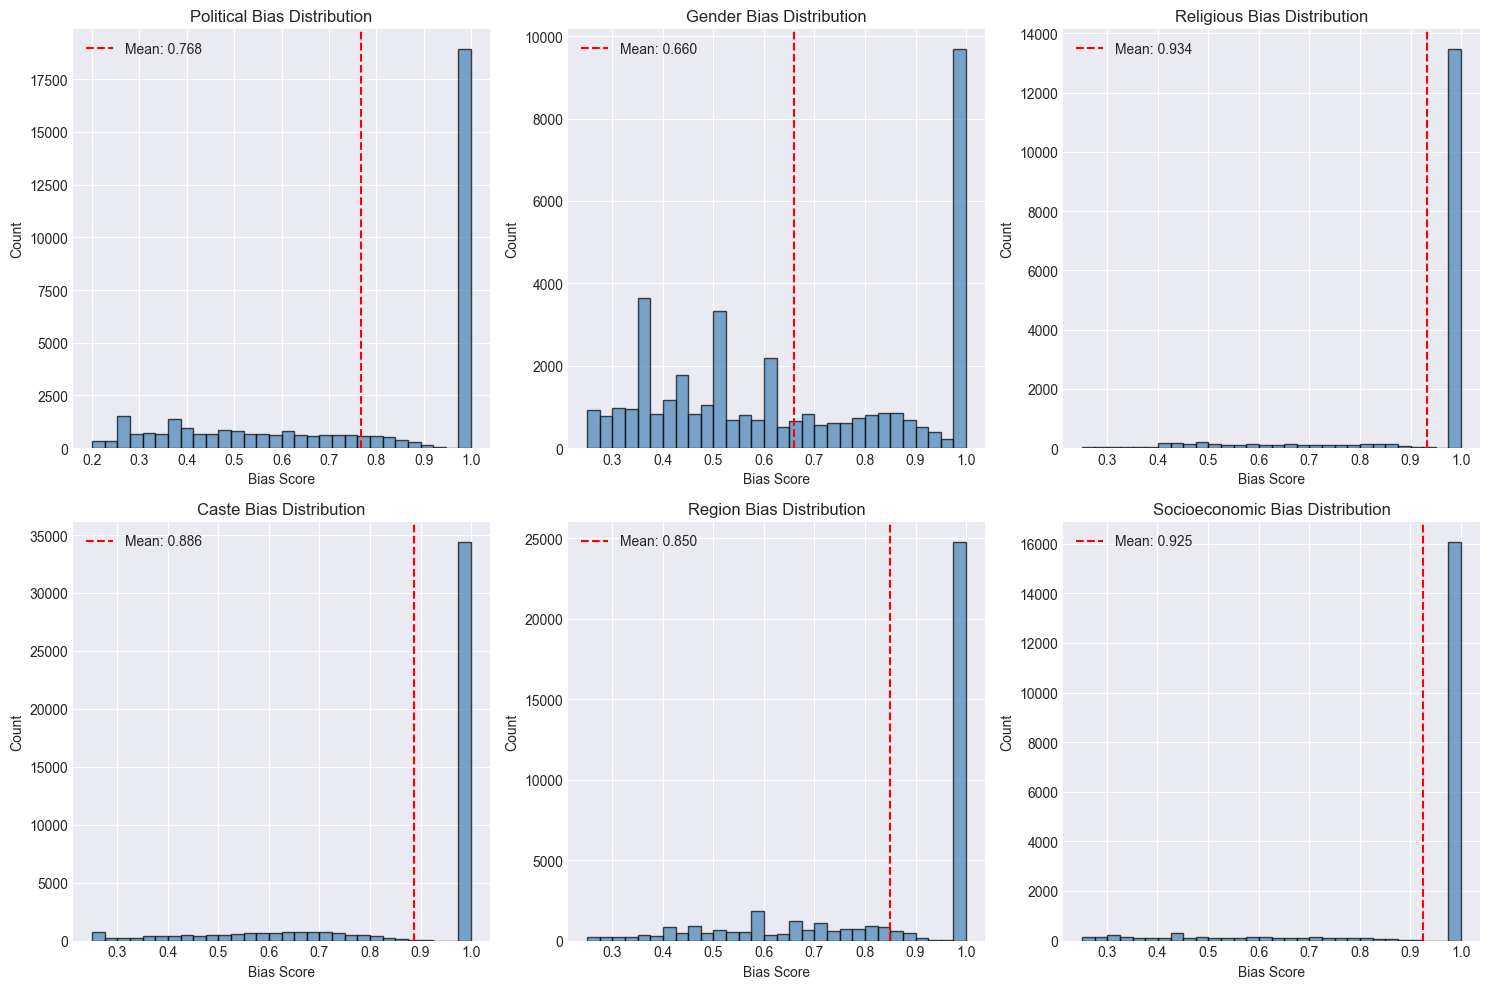

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, dim in enumerate(bias_dimensions):
    ax = axes[idx]
    col = f"ensemble_{dim}_bias"

    # Filter non-zero values for histogram
    non_zero = df[df[col] > 0][col]

    if len(non_zero) > 0:
        ax.hist(non_zero, bins=30, color="steelblue", edgecolor="black", alpha=0.7)
        ax.axvline(
            non_zero.mean(),
            color="red",
            linestyle="--",
            label=f"Mean: {non_zero.mean():.3f}",
        )
        ax.legend()

    ax.set_title(f"{dim.capitalize()} Bias Distribution")
    ax.set_xlabel("Bias Score")
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

#### Key insights: Bias score distributions across dimensions

1) Identity-based biases are very high and concentrated: Religious, caste, region, and socioeconomic bias scores are heavily skewed toward 1.0, with high means (≈0.85–0.93), indicating many articles are flagged as strongly biased on these dimensions.

2) Political and gender bias are lower and more spread out: Political and especially gender bias have lower means and wider distributions across mid–high scores, suggesting more variation and a larger share of articles with only moderate bias compared to the other dimensions.

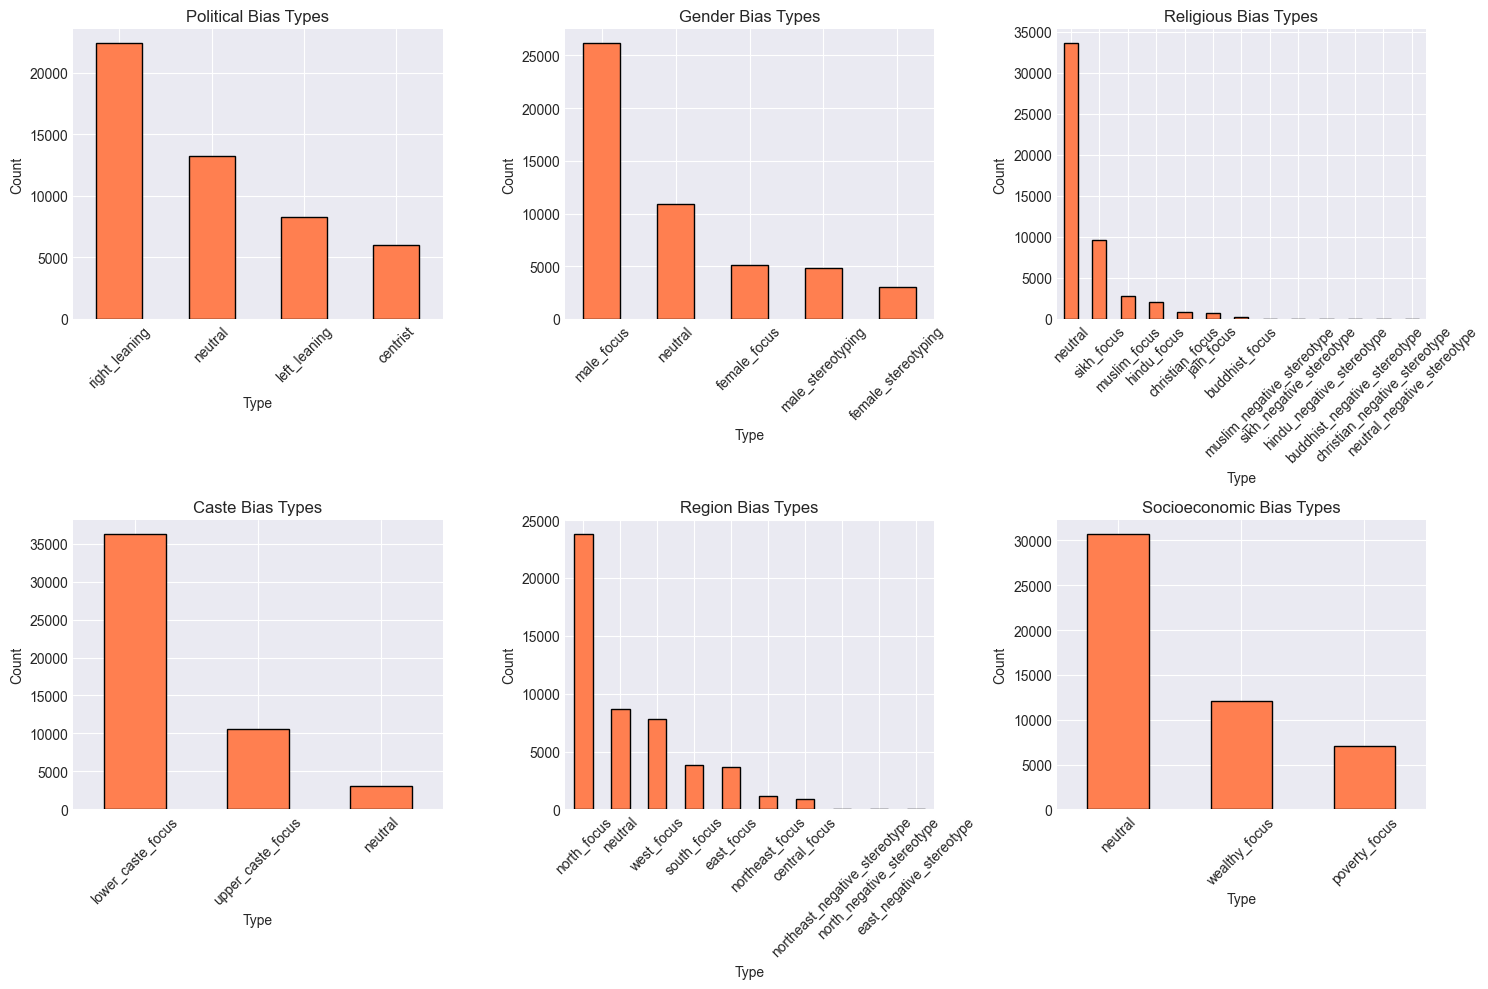

In [ ]:
# Bias type distribution
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, dim in enumerate(bias_dimensions):
    ax = axes[idx]
    col = f"ensemble_{dim}_type"

    type_counts = df[col].value_counts()
    type_counts.plot(kind="bar", ax=ax, color="coral", edgecolor="black")

    ax.set_title(f"{dim.capitalize()} Bias Types")
    ax.set_xlabel("Type")
    ax.set_ylabel("Count")
    ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

#### Key insights: Bias types across dimensions

1) Coverage is skewed toward specific groups: Political articles are mostly right_leaning, gendered coverage is dominated by male_focus, caste coverage heavily emphasizes lower_caste_focus, and region pieces often use non_focus or west_focus framing.

2) Neutral and stereotype categories coexist: While neutral remains a major class for religion, region, and socioeconomic bias, there are still non-trivial counts of explicit group‑focused and negative stereotype types, especially in religious and regional bias categories.

 ## 7. Overall Bias Score Distribution

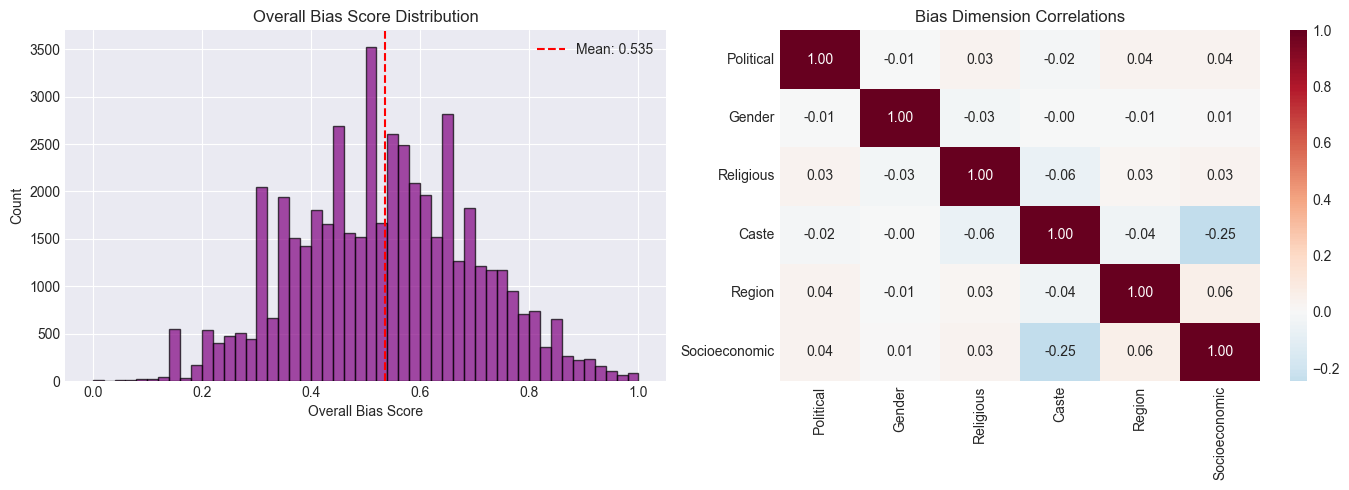

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1 = axes[0]
df["ensemble_overall_bias_score"].hist(
    bins=50, ax=ax1, color="purple", edgecolor="black", alpha=0.7
)
ax1.axvline(
    df["ensemble_overall_bias_score"].mean(),
    color="red",
    linestyle="--",
    label=f'Mean: {df["ensemble_overall_bias_score"].mean():.3f}',
)
ax1.set_title("Overall Bias Score Distribution")
ax1.set_xlabel("Overall Bias Score")
ax1.set_ylabel("Count")
ax1.legend()

# Correlation heatmap
ax2 = axes[1]
bias_cols = [f"ensemble_{dim}_bias" for dim in bias_dimensions]
corr_matrix = df[bias_cols].corr()

# Rename columns for display
display_names = {f"ensemble_{dim}_bias": dim.capitalize() for dim in bias_dimensions}
corr_matrix = corr_matrix.rename(columns=display_names, index=display_names)

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="RdBu_r", center=0, ax=ax2)
ax2.set_title("Bias Dimension Correlations")

plt.tight_layout()
plt.show()

#### Key insights: Overall bias and correlations

1) Most articles show moderate overall bias: The overall bias score distribution is centered around a mean of ≈0.54, with relatively few articles at very low or very high bias, suggesting that bias is generally present but rarely extreme.

2) Bias dimensions are largely independent: The correlation heatmap shows near‑zero relationships between most bias dimensions, with only a modest negative correlation between caste and socioeconomic bias (≈−0.25), indicating that different types of bias tend to appear separately rather than together.

 ## 8. High Bias Articles Analysis

In [ ]:
# Identify high-bias articles
high_bias_threshold = 0.3
df["is_high_bias"] = df["ensemble_overall_bias_score"] >= high_bias_threshold

print(f"\nHigh Bias Articles (score >= {high_bias_threshold}):")
print(f"  Count: {df['is_high_bias'].sum():,} ({df['is_high_bias'].mean() * 100:.1f}%)")

# Show examples
high_bias_df = df[df["is_high_bias"]].sort_values(
    "ensemble_overall_bias_score", ascending=False
)

if len(high_bias_df) > 0:
    print(f"\nTop 5 Highest Bias Articles:")
    print("-" * 80)
    for idx, row in high_bias_df.head(5).iterrows():
        title = row.get("title", row["text_for_analysis"][:100])
        print(f"\nScore: {row['ensemble_overall_bias_score']:.3f}")
        print(f"Title: {str(title)[:80]}...")
        print(
            f"  Political: {row['ensemble_political_bias']:.3f} ({row['ensemble_political_type']})"
        )
        print(
            f"  Religious: {row['ensemble_religious_bias']:.3f} ({row['ensemble_religious_type']})"
        )
        print(
            f"  Caste: {row['ensemble_caste_bias']:.3f} ({row['ensemble_caste_type']})"
        )


High Bias Articles (score >= 0.3):
  Count: 46,689 (93.5%)

Top 5 Highest Bias Articles:
--------------------------------------------------------------------------------

Score: 1.000
Title: Gujarat top cops letter blamed BJP leader for Delhi Darwaza riot in 2002...
  Political: 1.000 (left_leaning)
  Religious: 1.000 (hindu_focus)
  Caste: 1.000 (lower_caste_focus)

Score: 1.000
Title: Nashik Simhastha Kumbh Mela will start from Oct 2026...
  Political: 1.000 (centrist)
  Religious: 1.000 (hindu_focus)
  Caste: 1.000 (lower_caste_focus)

Score: 1.000
Title: US being attacked by Toxic extremist group within Islam: Senator...
  Political: 1.000 (right_leaning)
  Religious: 1.000 (muslim_focus)
  Caste: 1.000 (lower_caste_focus)

Score: 1.000
Title: Lara pained as WI get Cairned...
  Political: 1.000 (centrist)
  Religious: 1.000 (christian_focus)
  Caste: 1.000 (lower_caste_focus)

Score: 1.000
Title: CPM urges review of apple support price...
  Political: 1.000 (right_leaning)
  Reli

 ## 9. Save Results

In [ ]:
# Remove temporary columns
columns_to_drop = ["text_for_analysis"]
df_save = df.drop(columns=[c for c in columns_to_drop if c in df.columns])

print(f"\nSaving results to {OUTPUT_FILE}...")
df_save.to_parquet(OUTPUT_FILE, index=False, compression="snappy")

print(f"Saved {len(df):,} articles with ensemble bias scores")
print(f"  File size: {OUTPUT_FILE.stat().st_size / 1024**2:.2f} MB")
print(f"  Columns: {len(df_save.columns)}")


Saving results to ../data/processed/articles_with_ensemble_bias.parquet...
Saved 49,926 articles with ensemble bias scores
  File size: 133.38 MB
  Columns: 40


 ## 10. Summary

INPUT: 49,926 articles
OUTPUT: `../data/processed/articles_with_ensemble_bias.parquet`

ENSEMBLE METHODS:
- Keyword matching (weight: 0.4)
- TF-IDF similarity (weight: 0.6)
- BERT embeddings (weight: 0.0)

BIAS DIMENSIONS ANALYZED:
- **Political**       | Articles with bias: 36,722 (73.6%)
- **Gender**          | Articles with bias: 39,070 (78.3%)
- **Religious**       | Articles with bias: 16,295 (32.6%)
- **Caste**           | Articles with bias: 46,867 (93.9%)
- **Region**          | Articles with bias: 41,217 (82.6%)
- **Socioeconomic**   | Articles with bias: 19,189 (38.4%)
